In [1]:
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
from pathlib import Path
import numpy as np
import pandas as pd
from time import time
from collections import Counter
import logging
import spacy

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

np.random.seed(42)

def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

logging.basicConfig(filename='preprocessing.log', level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')

In [2]:
sec_path = Path('data', 'sec-filings')
filing_path = sec_path / 'filings'
sections_path = sec_path / 'sections'
if not sections_path.exists():
    sections_path.mkdir(exist_ok=True, parents=True)

In [78]:
for i, filing in enumerate(filing_path.glob('*.txt'), 1):
    if i % 500 == 0:
        print(i, end=' ', flush=True)
    filing_id = int(filing.stem)
    items = {}
    for section in filing.read_text(encoding='UTF8').lower().split('°'):
        if section.startswith('item '):
            if len(section.split()) > 1:
                item = section.split()[1].replace('.', '').replace(':', '').replace(',', '')
                text = ' '.join([t for t in section.split()[2:]])

                # if i == 13:
                #     print(f'2 filing.stem:{item} \t{filing.stem}\n{text[:40]}')

                if items.get(item) is None or len(items.get(item)) < len(text):
                    items[item] = text

    txt = pd.Series(items).reset_index()
    txt.columns = ['item', 'text']

    txt.to_csv(sections_path / (filing.stem + '.csv'), index=False)

500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 10000 10500 11000 11500 12000 12500 13000 13500 14000 14500 15000 15500 16000 16500 17000 17500 18000 18500 19000 19500 20000 20500 21000 21500 22000 22500 

In [85]:
# Parse Sections

# Item 1 and 1A: Business and Risk Factors
# Item 7: Management's Discussion
# Item 7a: Disclosures about Market Risks
sections = ['1', '1a', '7', '7a']

clean_path = sec_path / 'selected_sections'

if not clean_path.exists():
    clean_path.mkdir(exist_ok=True)

# load english version MDL: en_core_web_sm
# pipeline disable : tokenizer, tagger, parser, ner(Named Entity Recognizer), lemmatizer, textcat, custom
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.max_length = 6000000

vocab = Counter()
t = total_tokens = 0
stats = []

start = time()
to_do = len(list(sections_path.glob('*.csv')))
done = len(list(clean_path.glob('*.csv'))) + 1
# print(f'to_do:{to_do} : {sections_path}')

for text_file in sections_path.glob('*.csv'):
    file_id = int(text_file.stem)
    clean_file = clean_path / f'{file_id}.csv'

    if clean_file.exists():
        continue

    items = pd.read_csv(text_file, encoding='UTF8').dropna()
    items.item = items.item.astype(str)
    items = items[items.item.isin(sections)]

    # print(f'file from {file_id} to {clean_file}\nitems:{items}')

    if done % 100 == 0:
        duration = time() - start
        to_go = (to_do - done) * duration / done
        print(f'{done:>5}\t{format_time(duration)}\t{total_tokens / duration:,.0f}\t{format_time(to_go)}')

    clean_doc = []
    for _, (item, text) in items.iterrows():
        doc = nlp(text)
        # print(f'\titem & text : {item} \t {text[:30]}')
        for s, sentence in enumerate(doc.sents):
            clean_sentence = []
            if sentence is not None:
                for t, token in enumerate(sentence, 1):
                    if not any([token.is_stop, token.is_digit, not token.is_alpha, token.is_punct,
                                token.is_space, token.lemma_ == '-PRON-',
                                token.pos_ in ['PUNCT', 'SYM', 'X']]):
                        clean_sentence.append(token.text.lower())
                total_tokens += t
                if len(clean_sentence) > 0:
                    clean_doc.append([item, s, ' '.join(clean_sentence)])
    (pd.DataFrame(clean_doc, columns=['item', 'sentence', 'text']).dropna().to_csv(clean_file, index=False))
    done += 1

  100	00:03:48	12,635	14:14:50
  200	00:06:45	12,620	12:37:42
  300	00:08:52	12,667	11:00:23
  400	00:11:58	12,640	11:04:45
  500	00:14:27	12,692	10:39:45
  600	00:16:40	12,773	10:12:11
  700	00:18:47	12,883	09:48:27
  800	00:21:23	12,996	09:43:36
  900	00:23:38	13,126	09:30:36
 1000	00:26:06	13,240	09:24:25
 1100	00:28:28	13,339	09:17:19
 1200	00:31:12	13,457	09:17:11
 1300	00:33:40	13,539	09:12:33
 1400	00:36:25	13,609	09:12:14
 1500	00:38:59	13,693	09:09:08
 1600	00:41:23	13,755	09:04:03
 1700	00:43:53	13,830	09:00:13
 1800	00:46:08	13,886	08:53:56
 1900	00:48:55	13,942	08:53:39
 2000	00:51:24	13,996	08:50:10
 2100	00:54:18	14,043	08:50:48
 2200	00:57:44	14,103	08:56:08
 2300	01:00:50	14,146	08:57:44
 2400	01:04:11	14,178	09:01:01
 2500	01:07:42	14,206	09:05:09
 2600	01:11:01	14,238	09:07:08
 2700	01:13:60	14,270	09:06:15
 2800	01:16:51	14,291	09:04:15
 2900	01:20:26	14,294	09:07:18
 3000	01:23:55	14,309	09:09:08
 3100	01:27:35	14,324	09:11:50
 3200	01:31:23	14,343	09:14:52
 3300	01

In [92]:
# Create ngrams
ngram_path = sec_path / 'ngrams'
stats_path = sec_path / 'corpus_stats'

for path in [ngram_path, stats_path]:
    if not path.exists():
        path.mkdir(parents=True)

unigrams = ngram_path / 'ngrams_1.txt'

def create_unigrams(min_length=3):
    texts = []
    sentence_counter = Counter()
    vocab = Counter()
    for i, f in enumerate(clean_path.glob('*.csv')):
        if i % 1000 == 0:
            print(i, end=' ', flush=True)
        df = pd.read_csv(f, encoding='UTF8')
        df.item = df.item.astype(str)
        df = df[df.item.isin(sections)]
        sentence_counter.update(df.groupby('item').size().to_dict())
        for sentence in df.text.dropna().str.split().tolist():
            if len(sentence) >= min_length:
                vocab.update(sentence)
                texts.append(' '.join(sentence))

    (pd.DataFrame(sentence_counter.most_common(), columns=['item', 'sentences'])
     .to_csv(stats_path / 'selected_sentences.csv', index=False))
    (pd.DataFrame(vocab.most_common(), columns=['token', 'n'])
     .to_csv(stats_path / 'sections_vocab.csv', index=False))

    unigrams.write_text('\n'.join(texts))
    return [l.split() for l in texts]

start = time()
if not unigrams.exists():
    texts = create_unigrams()
else:
    texts = [l.split() for l in unigrams.open()]
print('\nReading: ', format_time(time() - start))

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 
Reading:  00:33:46


In [7]:
stats_path

In [5]:
def create_ngrams(max_length=3):
    """Using gensim to create ngrams"""

    n_grams = pd.DataFrame()
    start = time()
    for n in range(2, max_length + 1):
        print(n, end=' ', flush=True)

        sentences = LineSentence(ngram_path / f'ngrams_{n - 1}.txt')
        phrases = Phrases(sentences=sentences, min_count=25,  # ignore terms with a lower count
                          threshold=0.5,  # accept phrases with higher score
                          max_vocab_size=40000000,  # prune of less common words to limit memory use
                          delimiter='_',  # how to join ngram tokens
                          progress_per=50000,  # log progress every
                          scoring='npmi')

        s = pd.DataFrame([[k, v] for k, v in phrases.export_phrases().items()],
                         columns=['phrase', 'score']).assign(length=n)

        # print(f's : {s}')
        n_grams = pd.concat([n_grams, s])
        grams = Phraser(phrases)
        sentences = grams[sentences]
        (ngram_path / f'ngrams_{n}.txt').write_text('\n'.join([' '.join(s) for s in sentences]))

    n_grams = n_grams.sort_values('score', ascending=False)
    n_grams.phrase = n_grams.phrase.str.replace('_', ' ')
    n_grams['ngram'] = n_grams.phrase.str.replace(' ', '_')

    n_grams.to_parquet(sec_path / 'ngrams.parquet')

    print('\n\tDuration: ', format_time(time() - start))
    print('\tngrams: {:,d}\n'.format(len(n_grams)))
    print(n_grams.groupby('length').size())

create_ngrams()

2 3 
	Duration:  00:19:39
	ngrams: 73,856

length
2    31791
3    42065
dtype: int64


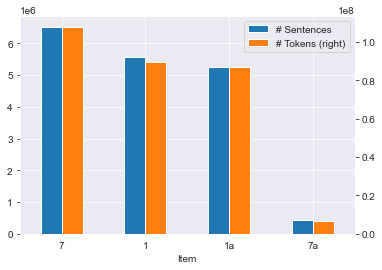

In [8]:
# Inspect Corpus
percentiles=np.arange(.1, 1, .1).round(2)

nsents, ntokens = Counter(), Counter()
for f in clean_path.glob('*.csv'):
    df = pd.read_csv(f)
    nsents.update({str(k): v for k, v in df.item.value_counts().to_dict().items()})
    df['ntokens'] = df.text.str.split().str.len()
    ntokens.update({str(k): v for k, v in df.groupby('item').ntokens.sum().to_dict().items()})

ntokens = pd.DataFrame(ntokens.most_common(), columns=['Item', '# Tokens'])
nsents = pd.DataFrame(nsents.most_common(), columns=['Item', '# Sentences'])
nsents.set_index('Item').join(ntokens.set_index('Item')).plot.bar(secondary_y='# Tokens', rot=0);

In [9]:
ngrams = pd.read_parquet(sec_path / 'ngrams.parquet')
ngrams.score.describe(percentiles=percentiles)
ngrams[ngrams.score>.7].sort_values(['length', 'score']).head(10)
vocab = pd.read_csv(stats_path / 'sections_vocab.csv').dropna()

In [10]:
ngrams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 1001 to 6601
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   phrase  73856 non-null  object 
 1   score   73856 non-null  float64
 2   length  73856 non-null  int64  
 3   ngram   73856 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
vocab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201560 entries, 0 to 201561
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   token   201560 non-null  object
 1   n       201560 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [12]:
ngrams.head()

,phrase,score,length,ngram
1001,dodd frank,2.307825,3,dodd_frank
654,table contents,2.085622,3,table_contents
999,sarbanes oxley,1.895722,3,sarbanes_oxley
1679,fannie mae,1.871327,3,fannie_mae
1399,black scholes,1.868592,3,black_scholes


In [13]:
vocab.n.describe(percentiles).astype(int)

count     201560
mean        1439
std        22330
min            1
10%            1
20%            2
30%            3
40%            4
50%            7
60%           12
70%           24
80%           61
90%          260
max      2575605
Name: n, dtype: int32

In [14]:
tokens = Counter()

for l in (ngram_path / 'ngrams_2.txt').open(encoding='UTF8'):
    tokens.update(l.split())

tokens = pd.DataFrame(tokens.most_common(), columns=['token', 'count'])
tokens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231142 entries, 0 to 231141
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   token   231142 non-null  object
 1   count   231142 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


In [15]:
tokens.head()

,token,count
0,million,2341139
1,business,1702656
2,december,1519278
3,company,1491442
4,products,1368864


In [16]:
tokens.loc[tokens.token.str.contains('_'), 'count'].describe(percentiles).astype(int)

count     30345
mean        921
std        9577
min           1
10%          26
20%          31
30%          37
40%          46
50%          60
60%          85
70%         130
80%         235
90%         660
max      594569
Name: count, dtype: int32

In [17]:
tokens[tokens.token.str.contains('_')].head(20).to_csv(sec_path / 'ngram_examples.csv', index=False)
tokens[tokens.token.str.contains('_')].head(20)

,token,count
47,year_ended,594569
64,results_operations,492465
70,table_contents,440550
79,company_s,414269
85,financial_condition,396221
86,common_stock,387690
107,fair_value,341206
152,united_states,276758
158,cash_flows,266939
169,financial_statements,255244


In [18]:
# Get returns
DATA_FOLDER = Path('data')

with pd.HDFStore(DATA_FOLDER / 'assets.h5') as store:
    prices = store['quandl/wiki/prices'].adj_close

sec = pd.read_csv(sec_path / 'filing_index.csv', encoding='UTF8').rename(columns=str.lower)
sec.date_filed = pd.to_datetime(sec.date_filed)
sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22631 entries, 0 to 22630
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cik           22631 non-null  int64         
 1   company_name  22631 non-null  object        
 2   form_type     22631 non-null  object        
 3   date_filed    22631 non-null  datetime64[ns]
 4   edgar_link    22631 non-null  object        
 5   quarter       22631 non-null  int64         
 6   ticker        22631 non-null  object        
 7   sic           22461 non-null  object        
 8   exchange      20619 non-null  object        
 9   hits          22555 non-null  object        
 10  year          22631 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 1.9+ MB


In [19]:
# Labeling filings with returns to predict earnings surprises
idx = pd.IndexSlice
first = sec.date_filed.min() + relativedelta(months=-1) # sec.date_filed.min() -1 month
last = sec.date_filed.max() + relativedelta(months=1) # sec.date_filed.min() +1 month
# resample('D') dividing by specific period - options: Y, M, D, H, T(min), S ...
# dropna(how='all') : toall axis=0/1 have to NaN to drop
# ffill() fill data by previous one
prices = (prices.loc[idx[first:last, :]].unstack().resample('D').ffill().dropna(how='all', axis=1)
          .filter(sec.ticker.unique()))
sec = sec.loc[sec.ticker.isin(prices.columns), ['ticker', 'date_filed']]

price_data = []
for ticker, date in sec.values.tolist():
    target = date + relativedelta(months=1)
    s = prices.loc[date: target, ticker]
    price_data.append(s.iloc[-1] / s.iloc[0] - 1)

df = pd.DataFrame(price_data, columns=['returns'], index=sec.index)
df.returns.describe()

count    11101.000000
mean         0.022839
std          0.126137
min         -0.555556
25%         -0.032213
50%          0.017349
75%          0.067330
max          1.928826
Name: returns, dtype: float64

In [20]:
sec['returns'] = price_data
sec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11375 entries, 0 to 22629
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ticker      11375 non-null  object        
 1   date_filed  11375 non-null  datetime64[ns]
 2   returns     11101 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 355.5+ KB


In [21]:
sec.dropna().to_csv(sec_path / 'sec_returns.csv', index=False)